In [1]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
%matplotlib inline
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure


<h1 style='text-align: center;'> Investigating the performance of the Metropolis and Wolff Cluster algorithims for the 2D Ising Model </h1> 


<h3 align="center">Abstract</h3> 

Monte Carlo techniques are used to explore the behaviour of the two-dimensional Ising model in Python. The performance of two algorithims are compared and analysed namely the Metropolis-Hastings and Wolff Cluster algorithim. Plots for the magnetic susceptibility and specific heat capacity of the system are obtained through the temperature dependence of the magnetisation and energy of the system, showing divergence at the critical temperature. Autocorellation of the respective frameworks is also investigaed verifying the disadvantages of a single flip procedure in contrast to the cluster flip method. The dynamic exponents of both algorithms are also obtained $z_{Metropolis}$ = 0.9327 ± 0.4025 and $z_{Wolff}$ = 0.1098 ± 0.0772 for the Metropolis and Wolff algorithms respectively. The value for the Metropolis is deviates from the expected value. The issue of critical slowing down is quantified further verifying the improvements made by the Wolff Cluster algorithm. 

<h3 align="center">1 . Introduction</h3> 

Monte Carlo methods are broadly applicable to various problems that are impossible to solve analytically and difficult to handle for other numerical techniques due to the large computational complexity. To give an example, in some cases it may be difficult to numerically explore the complete phase space of a thermodynamic system. MC methods act as an alternative to averaging over all states to calculate thermodynamic quantities. They instead obtain random samples of the phase space which is sufficient in order to compute ensemble averages of particular thermodynamic quantities. If the number of samples is large enough, the computed estimate converges toward the correct value. In this report, we outline the algorithims used and discuss the implementation relevant to calculate quantities such as the mean magnetisation, energy, heat capacity and magnetic susceptibility for the Ising model. We further analyse the execution of the Metropolis and Wolff cluster algorithims including their autocorrelation times as well as discussing the issue of critical slowing down.

<h3 align="center">2  Theoretical Background</h3> 

<h4 align="center">2.1 Ising Model</h4> 

The Ising model was intially a problem proposed by physicist Wilhelm Lenz to his doctoral student Ernst Ising to describe systems composed of magnetic dipole moments [1]. However, the model is not restricted to this. The model can be used in three kinds of physical systems: (1) magnets, in which each molecule has a "spin" that can be oriented either up or down relative
to the direction of an externally applied field; (2) mixtures of two kinds of molecules; (3) mixtures of molecules and "holes"(empty spaces) . All three kinds can be represented abstractly by the same model, if we simply say that each node of a regular space lattice is assigned a two-valued variable. Depending on whether
this variable has the value $+1$ or $-1$, we say that the molecule at that node (1) has spin up or down, or (2)
belongs to one or the other of two species, (3) is present or absent. In this instance, we are interested in the first case where the two-valued variable is denoted the spin $\sigma_i$ , associated with node $i$ of the lattice.


The original goal was to model phase transitions in magnetic materials. As a part of his doctoral thesis in 1924, Ernst Ising concluded that the one-dimensional case exhibits no phase transition. For that reason, it was expected at the model would be of no particular use. Later in 1944, Lars Onsager solved for spins in two-dimensions with a mathematical "tour de force", deriving the partition function for the Ising model without the presence of an external magnetic field, finding a critical point at temperature $T_c$ , and later in 1949 published an equation to describe the temperature dependence of the magnetisation[2]. Onsager provided no proof for his formula, but it is known that he derived it using Toeplitz determinants [3]. A few years passed until a proof was established by Yang in 1952 [4].

Since then, the Ising model has been applied successfully to numerous physical and non-physical problems, including magnetic systems, binary mixtures, and models of opinion formation. When compared with experimental data, the Ising model has generally been found to agree well with observations made for certain magnetic materials. However, there is still no general analytical solution for the Ising model in three dimensions, which is why this mathematical model has been studied extensively from a numerical perspective. Tools from statistical physics have been employed for this purpose, some of which are described in this section.

We begin our discussion of the properties of the Ising model by considering the $N$ spins in binary states $\sigma_i$ $\in$ $\{1,-1\}$ arranged on a one-, two-, or three-dimensional lattice. The spins may only interact with spins on with their nearest-neighbour spins. The energy of the system is given by the Hamiltonian of the model,
$$
\begin{equation}
    \mathcal{H} = -\mu H \sum^{N}_i \sigma_i -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j  
\end{equation}
$$ where we sum over all spins 
 and their neighbours 
 with exchange energy $J$, the notation $\langle i,j \rangle$ is a sum over nearest neighbours for each given point
, magnetic moment 
$\mu$ , and $H$ an externally applied magnetic field. The ferromagnetic case where $J$ > 0 , favours parallel spins and can lead to the phenomenon of spontaneous magnetisation, that is, a non-zero magnetisation, $M$ , which occurs even when
$H$ = 0, due to the potential energy of interaction between the spins. At $T$ = 0 we expect all the
spins to be aligned. If the temperature is increased we expect the spins to become progressively
more disordered, so that $H$ will decrease. At this stage one can raise the objection that if $H$ = 0 then for each configuration of the spins there is another configuration of equal energy in which
the direction of every spin is reversed. These two states are of equal energy and have equal weight in the partition function, and therefore the average magnetisation must be zero. If $J$ < 0, the system is called antiferromagnetic, because antiparallel spins lead to an
energy minimization. No interaction occurs for $J$ = 0. 
<br/>

In the case of a ferromagnetic
Ising system, the first term tries to create order by minimizing the overall
energy as a consequence of aligning spins in the same direction. The second term tends to align the spins in the direction of the external field $H$. In an ordered state, the energy is lower, but thermal fluctuations disrupt the order by flipping individual spins. When the temperature exceeds a critical value $T_c$ , these fluctuations take over the system, and it becomes impossible to observe any long-range spin alignment. However, the domains of aligned spins grow as the temperature decreases below the critical
value. The critical temperature is determined by the underlying lattice and has been analytically calculated by Kramers and Wannier in 1941 [5] and Onsager in 1944 [2] for a two-dimensional square lattice. For a two-dimensional square lattice, the critical temperature is given by,
$$
T_c = \frac{2J}{log(1+\sqrt{2})} \approx 2.269J
$$

At a given temperature, the probability for a system to be in a particular configuration $X$ with energy $E(X)$ is,
$$
\begin{equation}
P(X) = \frac{1}{Z}e^{-\beta E(X)}
\end{equation}
$$ 
with partition function,
$$ 
\begin{equation}
Z = \sum_{X} e^{-\beta E(X)}
\end{equation}
$$ where $\beta$ = $\frac{1}{k_BT}$ is the inverse temperature. 

We define the ensemble average of a observable $O$ within the canonical ensemble to be,
$$
\begin{equation}
\langle O \rangle = \frac{1}{Z} \sum_X O(X)e^{-\beta E(X)}
\end{equation}
$$ 
where $O(X)$ is the value of $O$ in configuration $X$ and  $E(X)$ is the energy in configuration $X$.

<h3 align="center">3 Computational Background</h3> 

<h4 align="center">3.1 Markov Chain Monte Carlo</h4> 

In most cases, sampling from the phase space of a physical system based on uniform random numbers is very inefficient because the underlying distribution may exhibit peaks and regions where it is virtually zero.
Let $(\Omega,P)$ be a probability space and consider a sequence of random variables $X_0$, $X_1$,.... $\in$ $\Gamma$ on a state space $\Gamma$ i.e. $X_i$ is a function $\Omega$  $\to$ $\Gamma$ for all $i$ $\ge$ $1$. The sequence  $X_1$,$X_2$,.... is regarded as Markov Chain if the random variables $X_i$ satisfy the Markov property,
$$
\begin{equation}
P(X_{i+1} \in A| X_j = x_j, 0 \le j \le 1) = P(X_{i+1} \in A| X_j = x_i)
\end{equation}
$$ for all $A$ $\in$ $\Gamma$ and $i$ $\ge$ $0$, meaning that the distribution of $X_{i+1}$  only depends on the previous $X_{i}$
and not on how the chain got to $X_{i}$ . Simply, new samples in the state space are produced in a memoryless fashion, only depending on the current state.

For a given probability distribution $\pi$ on a sample space $\Gamma$, we can find an irreducible transition matrix $\mathbb{P}$ that that has $\pi$ as a stationary distribution i.e. $\pi$$\mathbb{P}$ = $\pi$ and applying the ergodic theorem to estimate the expectation values of observables within the system. The ergodic theorem states if the transition matrix $P$ on a finite state space is irreducible, then for any function $f$ : $\Gamma$ $\to$ $\Re$, the sample mean converges the expectation value.
$$
\begin{equation}
\lim_{n \to \infty} \bar{f(X)_n} = \lim_{n \to \infty} \frac{1}{n}\sum^n_{i=1} f(X_i)  \to \mathbb{E}(f(X))
\end{equation}
$$  Note that the stationarity condition $\pi P=\pi$ is equivalent to requiring the following identity for all $y \in \Gamma$:
$$ 
\begin{equation}
\sum_{x \in \Gamma} \pi(x) P(x \to y) = \pi(y) = \pi(y) \sum_{x \in \Gamma} P(y  \to  x)= \sum_{x \in \Gamma}  \pi(y) P(y \to  x)
\end{equation}
$$
This can be interpreted as a balance condition. The left-hand side gives the total flow of probability from any state $x$ into $y$, while the right-hand side gives the flow out of $y$ to any state $x$. In equilibrium, i.e. in the stationary distribution, these two flows must be equal. The simplest way to ensure this balance condition is to require **detailed balance**,
$$
\begin{equation}
\pi(x) P(x \to y) =  \pi(y) P(y  \to  x)
\end{equation}
$$

meaning that not just the total flow in and out of state $y$ is balanced, but that the flow between any two states $x$ and $y$ is the same in both directions.

<h4 align="center">3.2 Metropolis Algorithim</h4> 

The first of the algorthims implmented to study the Ising model is named after Nicolas Metropolis and was generalised by Hastings in the 1970s. The algorithim allows us to construct a transition matrix $P(x \to y)$ satisfying detailed balance for a desired distribution $\pi$. We first input an irreducible transition matrix $Q( x \to y)$ on the state space that has a stationary distribution different from $\pi$, and derives from it a new irreducible and aperiodic transition matrix $P(x \to y)$ with the desired stationary distribution. If the state of the Markov chain after $i$ steps is $X_i$, then the next state is chosen as follows. A random state $Y$ is sampled according to the transition matrix $Q( x\to y)$, meaning with **proposal probability** $\mathbb{P}(Y = y | X_i = x) = Q( x\to y).$ With a to-be-determined **acceptance probability** $A( x\to y)\in[0,1]$ this state is accepted ($X_{i+1}=Y$) and otherwise rejected ($X_{i+1}=X_i$), i.e. we set

$$ 
X_{i+1} = \begin{cases} Y & \text{with probability }A(X_i \to Y) \\ X_i & \text{otherwise}\end{cases}.
$$

The resulting transition matrix $P(x\to y) = \mathbb{P}(X_{i+1}=y|X_i=x)$ satisfies

$$ 
P(x\to y) = Q(x\to y)A(x\to y)\qquad\text{for }x\neq y.
$$

It satisfies detailed balance precisely when

$$ 
\pi(x) Q(x\to y)A(x\to y) = \pi(y) Q(y\to x)A(y\to x)\qquad \text{for all }x,y\in \Gamma.
$$

We only need to consider the case $\pi(x)Q(x\to y)>0$, because if it were zero the transition $x\to y$ would never be proposed anyway. Let us write $A(y\to x) = s\,\pi(x) Q(x\to y)$ for some $s \geq 0$. Detailed balance then implies $A(x\to y) = s\,\pi(y) Q(y\to x)$. Since both probabilities have to be less than or equal to $1$, the optimal choice is

$$ 
\begin{equation}
s = \frac{1}{\max\left( \pi(y)Q(y\to x),\, \pi(x)Q(x\to y)\right)}.
\end{equation}
$$

This results in the **Metropolis-Hastings acceptance probability**

$$ 
\begin{equation}
A(x\to y) = \min\left( 1, \frac{\pi(y)Q(y\to x)}{\pi(x)Q(x\to y)}\right).
\end{equation}
$$

Note that if $Q$ is irreducible and $Q(y \to x) > 0$ whenever $Q(x\to y)>0$, then $P$ is automatically irreducible as well because with non-zero probability a sequence of transitions proposed by $Q$ is fully accepted. Note also the important property that the acceptance probability depends only on the ratio $\pi(y)/\pi(x)$, so it fulfills the wish we had that the algorithm

For a two-dimensional lattice of size $w$ x $w$ $=$ $N$ with no external field, for a state space $\Gamma$ $\in$ $\{1,-1\}$ that approaches the desired Boltzmann distribution, 
$$
\begin{equation}
\pi(\sigma) = \frac{1}{Z}e^{-\beta E(\sigma)} 
\end{equation}
$$ where the energy is given by,
$$
\begin{equation}
E(\sigma) = -J\sum_{\langle i,j \rangle} \sigma_i \sigma_j 
\end{equation} 
$$ and $\sigma$ $\equiv$ $(\sigma_1,......\sigma_N)$ $\in$ $\{1,-1\}^N$.

At each step of the Markov chain a random site $i$ is from a uniform random distribution is selected and flipped $\sigma_i$ $\to$ $\sigma^{'}_i$ $=$ $-\sigma_i$. The simplest irreducible transition matrix $Q(x \to y)$ is  one that uniformly selects a site $i$ on the lattice and flips the spin, i.e.$$Q(x \to y) = \frac{1}{N} \mathbf{1}_{\{x\text{ and }y\text{ differ by exactly one spin}\}}.$$It is irreducible because with enough single spin flips we go from any state to any other state.

Note also that by its definition $Q(x\to y)=Q(y\to x)$. The Metropolis-Hastings algorithm prescribes that we accept such a spin flip from state $x$ to $y$ with probability
$$
A(x \to y) = \min\left( 1, \frac{\pi(y)Q(y\to x)}{\pi(x)Q(x\to y)}\right)= \min\left( 1, e^{\beta E(x)-\beta E(y)}\right) = 
\begin{cases} 1 & \text{if }E(y) \leq E(x) \\ e^{-\beta(E(y)-E(x))} &\text{if }E(y) > E(x) 
\end{cases}
$$

So if the spin flip lowers the energy it is always accepted, while if it increases the energy it is only accepted with a probability that decreases exponentially with increasing energy difference. The energy difference is easily calculated to be

$$
\Delta E = E(y) - E(x) = 2J \sum_{\langle i,j \rangle} \sigma_i  \sigma_j 
$$

where the sum is over the $4$ neighbors $j$ of $i$.

<h5 align="center">3.2.1 Algorithim Implementation</h5> 

For simplicity, we will consider the case of zero magnetic field $H$=$0$. 
1. Define an set of $N$ variables as an array $width$ x $width$ = $N$ which take values $\pm$ $1$ abiding by periodic boundary conditions.T hat is, we specify that the spins on one edge of the lattice are neighbours of the corresponding spins on the other edge. This ensures that all spins have the same number of neighbours and local geometry, and that there are no special edge spins which have different properties from the others; all the spins are equivalent and the system is completely translationally invariant.
2. Compute the energy difference to use the Metropolis-Hastings acceptance probability.
3. Use the acceptance probability to determine whether the spin is flipped.
4. Repeat for $N$ sites 


As an example the following code will execute the algorithm as described and will illustrate the evolution of the lattice.

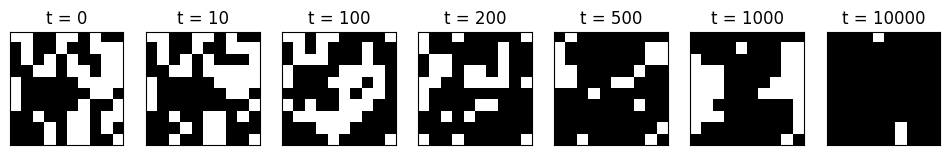

Elapsed time: 0.624982 seconds


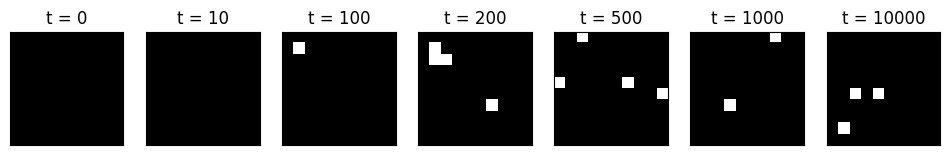

Elapsed time: 0.498477 seconds


In [2]:
import time


def time_function(func, *args, **kwargs):
    """
    This function takes in a function and calculates the time taken to execute it.
    It can also take in optional positional and keyword arguments to pass to the function.
    """
    start_time = time.time()  # Start timer
    result = func(*args, **kwargs)  # Call the input function with any optional arguments
    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")  # Print elapsed time in seconds
    return result  # Return the result of the input function (optional)

def init_lattice(width,type):
    """ init_lattice(width,type): Initializes the lattice of spins, given a width and a type of either 1, 0, or -1 denoting all up spins, a mixture of up and down, finally all down .The lattice is represented as a 2D numpy array."""
    lattice =[]
    if type == 1:
        lattice = np.ones((width,width)) #
    elif type == 0:
        lattice =np.random.choice([-1,1],size=(width,width))
    elif type ==-1:
        lattice = -np.ones((width,width))
    else:
        print("Invalid type, please enter 1,0 or -1")
    return lattice
def plot_lattice(lattice,ax,title):
    """ plot_lattice(lattice,ax,title): Plots the lattice of spins as a binary grid where 1 is white and -1 is black. """
    ax.matshow(lattice, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

def attempt_spin_flip_met(lattice,p):
    '''Here we will attempt to flip a spin at a random position in the lattice with probability p using the Metropolis-Hastings algorithm '''
    w = len(lattice)
    i,j = np.random.randint(0,w,2) #Randomly select a position in the lattice
    neighbour_sum = lattice[i,j]*(lattice[(i+1)%w,j] + lattice[(i-1)%w,j] + lattice[i,(j+1)%w] + lattice[i,(j-1)%w]) #Sum of neighbouring spins accounting for periodic boundary conditions
    if neighbour_sum <= 0 or np.random.rand() < p**neighbour_sum:
        lattice[i,j] *= -1
    

def illustrate_evolution(lattice,plot_times):
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,5))
    for t in range(plot_times[-1]+1):
        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t))
        attempt_spin_flip_met(lattice,p)
    plt.show()
#Setting parameters 
betaJ = 0.48
width = 10
p = np.exp(-2*betaJ)
plot_times = [0,10,100,200,500,1000,10000]
#PLotting the grid for a intially random a lattice and one where all spins are alligned.
lattice = init_lattice(width,0)
time_function(illustrate_evolution,lattice,plot_times)
lattice = init_lattice(width,1)
time_function(illustrate_evolution,lattice,plot_times)

def simulate_metropolis(lattice,steps):
    '''simulate_metropolis(lattice,steps): Simulates the evolution of the lattice for a given number of steps and returns the final lattice'''
    for t in range(steps):
        attempt_spin_flip_met(lattice,p)
    return lattice


#total magnetisation is the modulus of the sum of all the spins
def total_magnetisation(lattice):
    return np.abs(np.sum(lattice))

def simulate_metropolis_multiple(lattice,steps,runs):
    '''simulate_metropolis_multiple(lattice,steps,runs): Simulates the evolution of the lattice for a given number of steps and returns the final lattice'''
    magnetisation = np.zeros(runs)
    w = len(lattice)
    for i in range(runs):
        lattice = init_lattice(width,0)
        lattice = simulate_metropolis(lattice,steps)
        magnetisation[i] = total_magnetisation(lattice)/w**2
    return magnetisation

def plot_magnetisation(magnetisation,steps):
    plt.plot(steps,magnetisation,label = "Average Spin", color = "black")
    plt.xlabel("Steps")
    plt.ylabel(r'$\langle m \rangle$')
    plt.title("Mean Magnetisation vs Steps")
    plt.show()










<h4 align="center">3.3 Wolff Cluster algorithim</h4> 

The Metropolis algorithim is a based on single spin flips. As a consequence of this particular update method, we have to wait sufficiently long before adding a new uncorrelated configuration to our averaging procedure. Otherwise, the considered samples may not be statistically independent.

The Wolff algorithim is a non-local spin flip method that changes the system from state $s$ to state $s'$ by flipping a group, or cluster, of like spins. A cluster $C$ is formed iteratively, starting with a single "seed" site $i_{\text{seed}}$ that is randomly selected from the lattice. The spin value $\sigma$ of the seed is noted, and the aim is to expand the cluster by adding neighboring sites that share the same spin $\sigma$, with the appropriate probability. Each site in the cluster should be visited once, with the seed being the first site to be visited. After visiting a site, each unvisited neighbor has an independent probability $p_{\text{add}}$ of being added to the cluster. The process ends when all unvisited sites have been visited. The resulting cluster is $C$, and to complete the Wolff transition, each spin in the cluster should be flipped to $-\sigma$. It should be noted that this algorithm is rejection-free, meaning that the resulting spin configuration $s'$ is guaranteed to be different from the original configuration $s$.

When implementing this algorithm, it is easier to flip the spins of the newly added sites directly at the moment they are added to the cluster. This simplifies the procedure because the full cluster does not need to be kept track of; only the unvisited sites in the cluster need to be monitored. Since only neighboring sites with spin $\sigma$ are added to the cluster, they are guaranteed to be unvisited (regardless of whether they are visited or unvisited by the original algorithm). 

It's important to note that the transformation from $s$ to $s'$ is uniquely determined by the cluster $C$, although there are many ways that the algorithm could have constructed the cluster. This means that any site in the cluster could have been the seed, and the order in which the remaining sites were added could have been different as well. However, it's important to observe that the possibilities for constructing $C$ are the same for both the forward and backward transformations, and by verifying the detailed balance for each particular construction of $C$, the detailed balance will hold for the union of all constructions. Therefore, we can assume that the seeds for both moves are chosen in the same place, and that neighbors are explored in the same order.

The probabilities for the transformations $s\to s'$ and $s'\to s$ differ only at the boundary of $C$, because the spins within $C$ are all aligned. Let $m + n$ be the length of the boundary of $C$, where $m$ is the number of edges separating aligned sites and $n$ is the number of edges separating anti-aligned sites. The probability of the cluster $C$ being selected in $s$ is proportional to $(1-p_{\text{add}})^m$, because for each of the $m$ edges there was an independent $1-p_{\text{add}}$ chance that the neighbor would not be added. Furthermore, note that the cluster could not have been extended to anti-aligned sites, so the $n$ edges bordering those sites do not contribute to the probability. For the state $s'$, the roles of $m$ and $n$ are interchanged, and so the probability is proportional to $(1-p_{\text{add}})^n$.

Hence,

$$
\frac{P(s\to s')}{P(s'\to s)} = (1-p_{\text{add}})^{m-n}.
$$

On the other hand, the energy difference between the two states is also determined entirely by $m$ and $n$, because the boundary is the only place where changes from aligned to anti-aligned occur (and vice versa). Examining the energy $E(s) = - J \sum_{i\sim j}s_i s_j$ ( here we have used $s$ instead of $\sigma$ to represent the spins) , we easily find

$$
E(s') = E(s) + 2 J m - 2Jn,
$$

implying that the ratio of the Boltzmann distribution is given by

$$
\frac{\pi(s')}{\pi(s)} = e^{-\beta(E(s')-E(s))} = e^{-2\beta J (m-n)}.
$$

Indeed, taking $p_{\text{add}} = 1-e^{-2\beta J}$ ensures detailed balance

$$
\frac{P(s\to s')}{P(s'\to s)} = \frac{\pi(s')}{\pi(s)}.
$$

<h5 align="center">3.3.1 Algorithim Implementation</h5> 

1. Choose a site randomly.
2. If the neighboring sites are in the same state, add them to the cluster with probability $p_{add}$=1 − $e^{2\beta J}$ .
3. Repeat this for every site on the boundary of the cluster until all bonds of the cluster have been visited exactly once.
4. Choose a new state for the cluster.
5. Repeat the procedure.

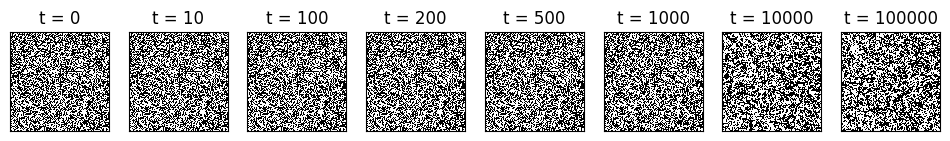

Elapsed time: 5.792638 seconds


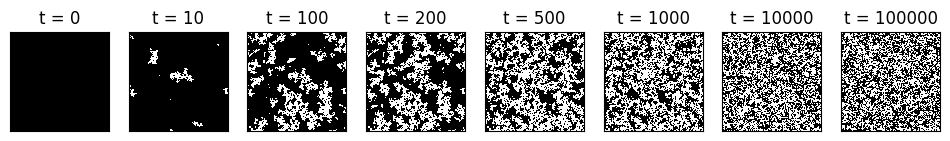

Elapsed time: 6.679044 seconds


In [3]:
from collections import deque 
'''Use double ended queue to efficiently track unvisited sites in the cluster'''

def neighboring_sites(lattice,w):
    '''Return the coordinates of the 4 sites adjacent to the chosen point on an w*w lattice.'''
    return [((lattice[0]+1)%w,lattice[1]),((lattice[0]-1)%w,lattice[1]),(lattice[0],(lattice[1]+1)%w),(lattice[0],(lattice[1]-1)%w)]

def cluster_flip(lattice,seed,p_add):
    '''Perform a single Wolff cluster move with specified seed on the state with parameter p_add.'''
    w = len(lattice)
    spin = lattice[seed]
    lattice[seed] = -spin  
    cluster_size = 1
    unvisited = deque([seed])   # use a deque to efficiently track the unvisited cluster sites
    while unvisited:   # while unvisited sites remain
        site = unvisited.pop()  # take one and remove from the unvisited list
        for nbr in neighboring_sites(site,w):
            if lattice[nbr] == spin and np.random.uniform() < p_add:
                lattice[nbr] = -spin
                unvisited.appendleft(nbr)
                cluster_size += 1
    return cluster_size

def wolff_cluster_move(lattice,p_add):
    '''Perform a single Wolff cluster move on the state with addition probability p_add.'''
    seed = tuple(np.random.randint(0,len(lattice),2))
    return cluster_flip(lattice,seed,p_add)
betaJ = 0.3
width = 200
p_add = 1-np.exp(-2*betaJ)
plot_times = [0,10,100,200,500,1000,10000,100000]
lattice = init_lattice(width,0)
def illustrate_evolution_wolff(lattice,plot_times):
    
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,4))
    for t in range(plot_times[-1]+1):
        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t))
        wolff_cluster_move(lattice,p_add)
    plt.show()
time_function(illustrate_evolution_wolff,lattice,plot_times)
lattice = init_lattice(width,1)
time_function(illustrate_evolution_wolff,lattice,plot_times)

It should be clear from the figures that the cluster Markov chain explores the state space a lot quicker than the single-spin flip Markov chain does. This does not yet imply that it is significantly faster in cpu time, because a single Wolff move in which many spins are flipped of course takes proportionally more time than a single-spin flip.

<h4 align="center">3.4 Equilibration</h4> 

In many cases of MCMC, the initial starting point, $X_0$, constructed by hand in a high-dimensional sample space is highly atypical. This means that for some observables $f:\Gamma\to\mathbb{R}$, $f(X_0)$ is significantly different from $\mathbb{E}[f(X)]$ by several standard deviations. This issue is exacerbated because the probability density $f_{X_i}(x)$ for $i\leq b$ is still far from the desired distribution $\pi(x)$, which is the reason we define the equilibration time, $\tau_{\mathrm{eq}}$. When $n$ is limited, the atypical configurations $X_i$ can contribute excessively to the time average $\frac{1}{n}\sum_{i=1}^n f(X_i)$, but their contribution becomes negligible as $n$ approaches infinity.

To estimate $\mathbb{E}[f(X)]$, we often discard the first $b$ configurations in the time average, where $b$ is chosen such that $b\geq \tau_{\mathrm{eq}}$. This allows us to take $\frac{1}{n-b}\sum_{i=b+1}^n f(X_i)$ as our best estimate of $\mathbb{E}[f(X)]$. The first $b$ steps in the MCMC simulation, during which we discard the observable $f(X_i)$, is referred to as the equilibration, thermalization, or burn-in phase of the simulation. This technique exploits the fact that although the limit of the time average is independent of the distribution of $X_0$, the convergence is faster when the distribution of $X_0$ is closer to $\pi$. To achieve this, we take the random state $X_b$ as a new effective starting point $X_0$ of the chain, which is close to $\pi$ for large $b$. We will discuss a technique to determine $\tau_{\mathrm{eq}}$ in the Ising model later.

<h4 align="center">3.5 Autocorrelation</h4> 

Suppose we know for our example that at time $i\geq b$ the distribution of $X_i$ is already sufficiently close to $\pi(x)$. Why is our estimate based on the time average $i=b+1,\ldots,$ in, even though we have a decent number of data points? The reason should be intuitively clear: the states $X_i$ are far from independent, meaning that each new state provides a small bit of extra information about the desired distribution $\pi$. 

Here we will estimate the error. We assume that $\operatorname{Var}(f(X)) < \infty$ and that $X_0$ has exactly the stationary distribution $\pi(x)$ (perhaps obtained by performing equilibration for a long time $b$ and then resetting the label $i$ of the state $X_i$ to $0$). By construction of the stationary distribution, the same holds for all $X_i$ with $i\geq 0$. In this case $\overline{f(X)}_n=\frac{1}{n}\sum_{i=1}^n f(X_i)$ is an unbiased estimator for $\mathbb{E}[f(X)]$ since 

$$
\mathbb{E}\left[\overline{f(X)}_n\right] = \frac{1}{n} \sum_{i=1}^n \mathbb{E}[f(X)] = \mathbb{E}[f(X)].
$$

For the variance we have

$$
\begin{split}
\operatorname{Var}\left(\overline{f(X)}_n\right) &= \mathbb{E}\left[\left(\overline{f(X)}_n- \mathbb{E}[f(X)]\right)^2\right] \\
& = \frac{1}{n^2}\sum_{i=1}^n\sum_{j=1}^n\mathbb{E}\Big[(f(X_i)-\mathbb{E}[f(X)])(f(X_j)-\mathbb{E}[f(X)])\Big]\\
& = \frac{1}{n^2}\sum_{i=1}^n\Bigg(\mathbb{E}\Big[(f(X_i)-\mathbb{E}[f(X)])^2\Big] \\
&\qquad\qquad+ 2\sum_{t=1}^{n-i}\mathbb{E}\Big[(f(X_i)-\mathbb{E}[f(X)])(f(X_{i+t})-\mathbb{E}[f(X)])\Big]\Bigg)\\
& = \frac{\operatorname{Var}(f(X))}{n}\left( 1 + 2 \sum_{t=1}^{n-1} \frac{n-t}{n}\rho(t)\right),
\end{split}
$$ 

where $\rho(t)$ is the **autocorrelation**

$$
\rho(t)=\operatorname{Corr}(f(X_i),f(X_{i+t})) := \frac{\mathbb{E}\Big[(f(X_i)-\mathbb{E}[f(X)])(f(X_{i+t})-\mathbb{E}[f(X)])\Big]}{\operatorname{Var}(f(X))}.
$$

We can estimate the latter via the **sample autocovariance**,

$$
 \bar{\gamma}(t) = \frac{1}{n-t} \sum_{i=1}^{n-t}(f(X_i) - \overline{f(X)}_n)(f(X_{i+t}) - \overline{f(X)}_n),
$$ 

from which one obtains the **sample autocorrelation** as 

$$
\begin{equation}
\bar{\rho}(t) = \frac{\bar{\gamma}(t)}{\bar{\gamma}(0)}
\end{equation}
$$

by normalizing $\bar{\gamma}(t)$ by the sample variance $\bar{\gamma}(0)$.
The formula for the sample-autocovariance is sometimes called the *unbiased* sample autocorrelation, but this is a bit of a misnomer because it is only unbiased if we replace $\overline{f(X)}_n$ by the known mean $\mathbb{E}[f(X)]$. The formula with $1/n$ is often found to be more stable numerically when $t$ approaches $n$, so keep that in mind. 

One may be tempted to take the sample autocorrelation $\bar{\rho}(t)$ and plug it in equation for the variance, to get an error estimate. However, in practice this rarely works, because the statistical errors in $\bar{\rho}(t)$ grow large when $t$ becomes of the order of $n$. It is often more convenient to estimate an **autocorrelation time** $\tau_f$ under the assumption that $\bar{\rho}(t)$ decays exponentially, i.e. $\bar{\rho}(t)\approx e^{-t/\tau_f}$. This can be done either by fitting an exponential curve or, slightly less accurately, by taking $\tau_f$ to be the first time $t$ that $\bar{\rho}(t)$ drops below $1/e$,

$$
\tau_f \approx \inf\{t : \bar{\rho}(t) < 1/e\}.
$$

If $1 \ll \tau_f \ll n$, then 

$$
\left( 1 + 2 \sum_{t=1}^{n-1} \frac{n-t}{n}\bar{\rho}(t)\right)\approx 2\sum_{t=1}^\infty e^{-t/\tau_f} \approx 2\tau_f.
$$

Therefore a rough $1\sigma$-estimate becomes

$$
 \mathbb{E}[f(X)] = \overline{f(X)}_n \pm \sqrt{\frac{2 \tau_{f}}{n} \,\bar{\gamma}(0)}.
$$

We have assumed that the measurements we have made have come from independent states, however since the algorithms change a finite number of spins at each iteration (especially in the Metropolis algorithm), the states used at each timestep may be statiscally correlated. For example, in
the Metropolis algorithm we have defined one timestep to be a sweep of the entire lattice. Thus we may expect that we have reached new state that is in no way correlated to the previous state. This is true for certain temperatures, however when we are close to a phase
transition i.e $T$ $\approx$ $T_c$ , in the critical region, the behaviour is not so trivial. A local change
algorithm such as Metropolis has no problem changing individual spins in this case as the nearest neighbours of each individual spin are, in general, a even mix of ’up’ and ’down’ spins. However, as we can see from our binary plots the neighbours of any given spin are likely to have four neighbours with like spins and thus we have a small $\Delta E$ which tends to make the probability of flipping very large. This causes the Metropolis algorithm to mostly change
the spins at the boundary of the clusters . It should now be clear that an entire sweep of the lattice is not enough to obtain an independent spin configuration. This also means that spins that are a finite distance apart may still have a mutual influence over one another. This introduces the variable of the correlation length $\zeta$.


<h4 align="center">3.6 Criticality</h4> 

Another natural observable is the energy $E(s)$, which, up to normalization and constant shift, counts the number of aligned nearest neighbor pairs in the configuration $s$.
Onsager calculated the mean absolute magnetization per spin [2] $\mathbb{E}{|m|}$ exactly in the limit of large lattices to be,

$$
\lim_{w\to\infty}\mathbb{E}[|m|] = \left( 1- [\sinh 2\beta J]^{-4}\right)^{\frac{1}{8}}.$$

Of course, this formula can only hold as long as $\sinh 2\beta J\geq 1$, i.e. $T\leq T_c$ where $T_c$ is the critical temperature

$$
T_c = \frac{2J}{\log(1+\sqrt{2})} \approx 2.269 J.
$$

For $T \geq T_c$ the magnetization vanishes, $\lim_{w\to\infty}\mathbb{E}[|m|] = 0$. Hence, the mean absolute-magnetization per site $\mathbb{E}[|m|]$ serves as an **order parameter** for the phase transition.
The magnetisation shows an interesting dependence on $\beta J$. A brute force calculation of the magnetisation would involve summing over $2^N$ terms.

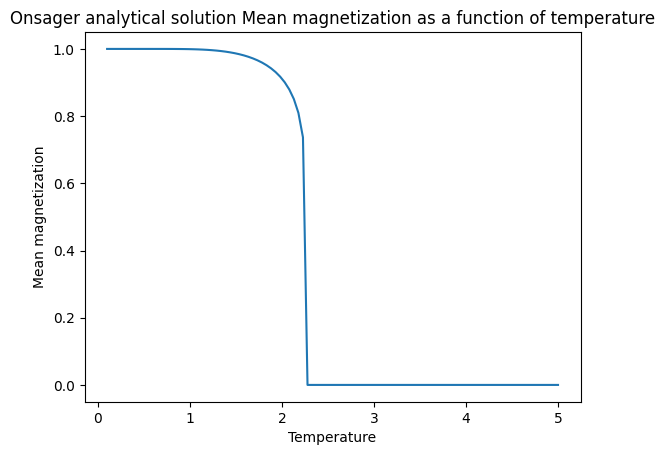

In [9]:
#Plotting the Onsagers analytical solution for the mean magnetization
def magnetisation(T):
    if T < 2/np.log(1+np.sqrt(2)):
        return (1-(np.sinh(2/T)**(-4)))**(1/8)
    else:
        return 0
T = np.linspace(0.1,5,100)
plt.plot(T,[magnetisation(t) for t in T])
plt.xlabel("Temperature")
plt.ylabel("Mean magnetization")
plt.title("Onsager analytical solution Mean magnetization as a function of temperature")
plt.show()

    


A phase transition that displays continuity in the order parameter throughout the transition is referred to as a "continuous phase transition." These transitions can have a significant impact on "correlation functions," which can be introduced in the case of the Ising model as:

$$
C(\vec{r}) = \mathbb{E}[s_{\vec{x}}s_{\vec{x}+\vec{r}}] - \mathbb{E}[s_{\vec{x}}]\mathbb{E}[s_{\vec{x}+\vec{r}}], \qquad \vec{r},\vec{x}\in\mathbb{Z}^2.
$$

where $s_{\vec{x}}$ refers to the spin at site $\vec{x}\in\mathbb{Z}^2$. Notably, due to translation symmetry, $C(\vec{r})$ is independent of $\vec{x}$. When $\vec{r}$ is significantly larger than the lattice spacing and $T\neq T_c$, $C(\vec{r}) \sim c e^{-|\vec{r}|/\xi}$, where $\xi$ represents the "correlation length."

One significant lesson derived from statistical physics is that continuous phase transitions yield "critical phenomena." As the temperature $T$ approaches the critical temperature $T_c$ on an infinite lattice, the correlation length $\xi$ diverges.

$$
 \xi \sim |T-T_c|^{-\nu}.
$$

The quantity $\nu$ is referred to as a "critical exponent." These values are of particular physical significance because they are not dependent on the specific parameters of the model or the type of lattice used (e.g., square or triangular). As a result, the critical exponent $\nu$ is considered a "universal" property of the Ising model.

At the exact critical temperature on an infinite lattice, the correlation length of the Ising model becomes infinite, resulting in the presence of spin clusters of every conceivable size. A feature of a statistical system at criticality is that it obtains a notion of "scale-invariance." If one zooms out enough such that individual lattice sites are no longer discernible, and the spin configuration has become continuous, then it becomes impossible to distinguish one configuration from another that is even more zoomed out.

The Metropolis-Hastings spin-flip Markov chain's autocorrelation time is severely affected by the critical correlation between distant spins, which is commonly referred to as critical slowing down. This phenomenon arises due to the inefficiency of the spin-flip algorithm in destroying large spin clusters that span across the entire lattice by performing only random single-spin flips. We can quantify this effect by looking at the **dynamic exponent** $z$ of the spin-flip algorithm, which is defined as the exponent appearing in the relation between the autocorrelation time $\tau$ in units of sweeps and the temperature $T$ or correlation length $\xi$,

$$
 \tau \sim |T-T_c|^{-z\nu} \sim \xi^z.
$$

On a finite lattice we cannot have $\xi > w$, so close to criticality we expect $\tau \sim w^z$. Since the value of $z$ for the spin-flip is estimated at $z \approx 2.17$, the auto-correlation time at criticality increases very rapidly with the lattice size.

Critical slowing down is a serious obstacle in many MCMC simulations. Luckily the dynamic exponent $z$ is not a universal property of the statistical model at hand, but depends on the chosen MCMC algorithm. In some cases it is possible to find algorithms that have much smaller exponents. Cluster algorithms are a particularly well-known family of these.

<h3 align="center">4 Results </h3> 

<h4 align="center">4.1 Magnetisation and Energy</h4> 

Thermodynamic systems are stochastic in nature. Thus, if we wish to measure a physical quantity or an observable, $O$, of the system , we must compute the the thermal average. 

The observables of particular interest in this report are the magnetisation and the internal energy of the system. The expectated values of these quantities can be evaluated using,
$$
\begin{equation}
\langle M \rangle = \frac{1}{Z} \sum_X M(X)e^{-\beta E(X)}
\end{equation}
$$
$$
\begin{equation}
\langle E \rangle = \frac{1}{Z} \sum_X E(X)e^{-\beta E(X)}
\end{equation}
$$

The analytical approach to compute the magnetisation would be to use the probability density function. However, computing partition function becomes quickly laborious for a lattice with a large number of sites. Central to Monte Carlo simulations, we can approximate the expection values as follows.

The mean magnetization per spin, $\langle m \rangle$, given by,
$$
\begin{equation}
\langle m \rangle = \langle \frac{1}{N} \sum^{N}_{i=1} \sigma_i \rangle ,
\end {equation}
$$ 

and corresponds to the ensemble average of the mean value of all spins. If the external field vanishes, the Hamiltonian is invariant under a simultaneous reversal of all spins.
In other words, a certain equilibrated configuration of spins would also have the same energy if we would change the sign of every single spin. Thus, the ensemble average defined would not be a good measure of the magnetization because it corresponds to an ensemble average over all possible configurations. For every temperature, $m(s)$ vanishes because for every configuration there exists a configuration of opposite sign which neutralizes it. Therefore, it is better to consider the **absolute magnetization** $|M(s)|$. 
In the limit $\beta \to \infty$ (or $T\to 0$) the only two states with positive probability $\pi(x)$ are the two completely aligned states, hence $\mathbb{E}[|m(s)|] = 1$. When $\beta = 0$ (or $T\to\infty$) the distribution $\pi(x)$ is uniform on all spin states. The difference between the number of $+1$ and $-1$ spins is then of the order $\sqrt{N}$, so $\mathbb{E}[|m(s)|] \approx N^{-1/2}$ is very small for decent size lattices.

Fluctuations of the magnetization can be used to determine the susceptibility using the fluctuation-dissipation theorem:
$$ 
\begin{equation}
\chi (T) = \frac{N}{k_BT}[\langle M^2 \rangle - \langle M \rangle^2]
\end{equation}
$$ the magnetic suscepitibility which quantifies the change of magnetisation in response to an applied field.


Analogously, the specific heat is connected to energy fluctuations via
$$
\begin{equation}
C (T) = \frac{1}{k_BT^2}[\langle E^2 \rangle - \langle E \rangle^2]
\end{equation}
$$

c:\Users\abdal\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


2.81 s ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
61.9 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


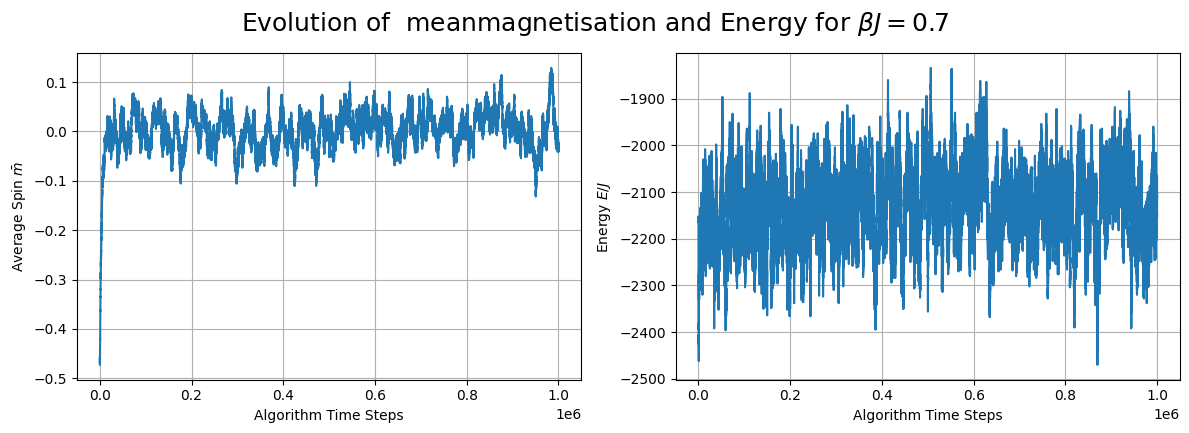

In [11]:
#Plotting the mean magnetization as a function of temperature for the Ising model
N=50
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1
def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

#run time of metropolis 
%timeit metropolis(lattice_n, 1000000, 0.2, get_energy(lattice_n))
#runtime of get energy
%timeit get_energy(lattice_n)
spins, energies = metropolis(lattice_n, 1000000, 0.2, get_energy(lattice_n))


fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of  mean magnetisation and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()



c:\Users\abdal\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


24.5 s ± 785 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


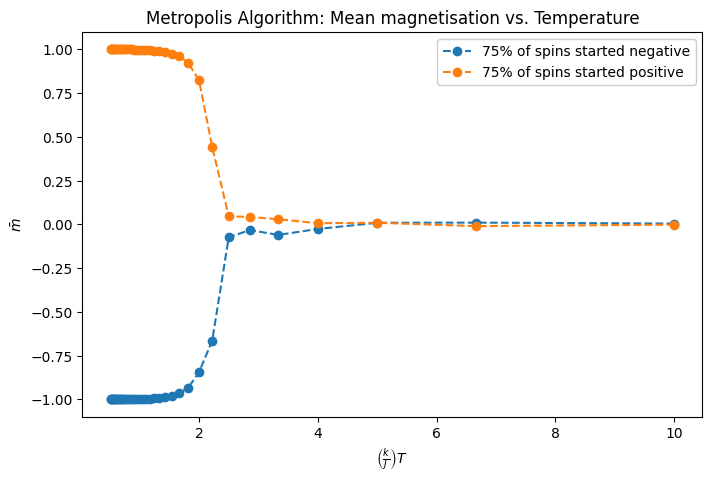

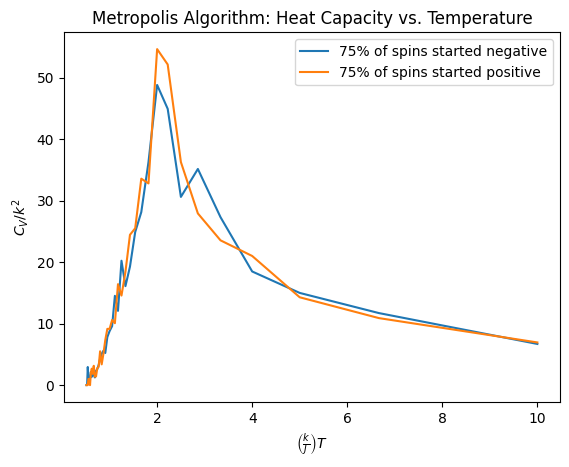

In [13]:

N = 50

def create_lattice(p):
    '''Intialise lattice'''
    init_random = np.random.random((N, N))
    lattice = np.zeros((N, N))
    lattice[init_random >= p] = 1
    lattice[init_random < p] = -1
    return lattice
#defining the lattice with 75% of the spins up and 25% of the spins down
lattice_n = create_lattice(0.75)
lattice_p = create_lattice(0.25)

def get_energy(lattice):
    '''Compute energy'''
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    '''Defines the Metropolis algorithm for the Ising model and returns the net spin and energy at each time step'''
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times - 1)
    net_energy = np.zeros(times - 1)

    neighbors = np.array([(-1, 0), (1, 0), (0, -1), (0, 1)], dtype=np.int32)

    for t in range(0, times - 1):
        x, y = np.random.randint(0, N, size=2)
        spin_i = spin_arr[x, y]
        spin_f = -spin_i

        E_i, E_f = 0, 0
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < N and 0 <= ny < N:
                E_i += -spin_i * spin_arr[nx, ny]
                E_f += -spin_f * spin_arr[nx, ny]

        dE = E_f - E_i
        if (dE > 0) * (np.random.random() < np.exp(-BJ * dE)):
            spin_arr[x, y] = spin_f
            energy += dE
        elif dE <= 0:
            spin_arr[x, y] = spin_f
            energy += dE

        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy

    return net_spins, net_energy
'''def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = spins[-100000:].mean() / N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds'''
#time get_spin_energy
#%timeit get_spin_energy(lattice_n, BJs)
#Parallelization - reduces the time taken to run the function by 250%
from concurrent.futures import ThreadPoolExecutor
''' You can parallelize the get_spin_energy function, which runs the metropolis function for different values of BJ. 
This can be done using Python's concurrent.futures module or other parallel processing libraries.'''
def parallel_get_spin_energy(lattice, BJs):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(metropolis, lattice, 1000000, bj, get_energy(lattice)) for bj in BJs]
        results = [future.result() for future in futures]

    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))

    for i, (spins, energies) in enumerate(results):
        ms[i] = spins[-100000:].mean() / N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()

    return ms, E_means, E_stds
#time parallel_get_spin_energy
%timeit parallel_get_spin_energy(lattice_n, BJs)
# Running the simulation for 75% of spins starting negative and 75% starting positive
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = parallel_get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = parallel_get_spin_energy(lattice_p, BJs)

# PLotting the results for 75% of spins starting negative and 75% starting positive on the same plot
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.title('Metropolis Algorithm: Mean magnetisation vs. Temperature')
plt.show()

plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.title('Metropolis Algorithm: Heat Capacity vs. Temperature')
plt.legend()
plt.show()

The code calculates the net spin and energy at each time step using the Metropolis algorithm for different values of the inverse temperature, $\beta J$. The simulation is run for two different lattices, one with 75% of spins starting negative and another with 75% of spins starting positive. The results are then plotted on two different graphs.

The first plot shows the average magnetization per spin, $\bar{m}$, as a function of the inverse temperature, $(\frac{k}{J})T$. The plot shows that the magnetization increases as the temperature decreases, indicating the tendency of the spins to align as the temperature decreases. We see beyond a particular temperature, the magnetisation reduces to zero indicating that the system has become disorded. 

The second plot shows the specific heat, $C_V$, as a function of the inverse temperature, $(\frac{k}{J})T$. The specific heat is a measure of the thermal energy of the lattice and is calculated as the variance of the energy over temperature. The plot shows that the specific heat increases as the temperature increases, indicating the tendency of the lattice to absorb more energy as the temperature increases. The plot also shows that the behavior of the lattice with 75% of spins starting negative is slightly different from the behavior of the lattice with 75% of spins starting positive but does diverge at near the critcal temperature.

Together, these plots provide evidence for the existence of a critical temperature, above which the lattice behaves differently than below it. The critical temperature can be estimated by looking for the temperature at which the magnetization changes rapidly or the specific heat diverges.

The parallelization in this code is used to speed up the execution of the **parallel_get_spin_energy** function, which runs the Metropolis algorithm for different values of the inverse temperature, $\beta J$. This function performs a large number of iterations to obtain the average magnetization and specific heat for the lattice for each value of $\beta J$, which can be computationally expensive. To speed up this process, the **ThreadPoolExecutor** class from the **concurrent.futures** module is used to run multiple instances of the Metropolis algorithm in parallel.

The **ThreadPoolExecutor class** creates a pool of threads, which can execute the Metropolis algorithm simultaneously on different values of $\beta J$. Each thread is assigned a specific value of $\beta J$ and runs the Metropolis algorithm for that value. Once all threads have completed their tasks, the results are collected and combined into the final output. This parallelization reduces the time taken to run the function by a factor of up to 250%.

The use of parallelization in this code demonstrates the potential benefits of using parallel processing techniques for computationally intensive tasks, such as simulations of physical systems. By distributing the workload across multiple processors or threads, the execution time of the task can be significantly reduced, making it feasible to perform simulations with larger datasets or higher resolution.

Numba is a just-in-time (JIT) compiler for Python that can be used to accelerate the performance of numerical algorithms. In the provided code, the **@numba.njit** decorator is used to compile the metropolis function using Numba's JIT compiler. This function is the main computational bottleneck of the code, as it implements the Metropolis algorithm for the Ising model, which involves a large number of iteration

27.3 s ± 2.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


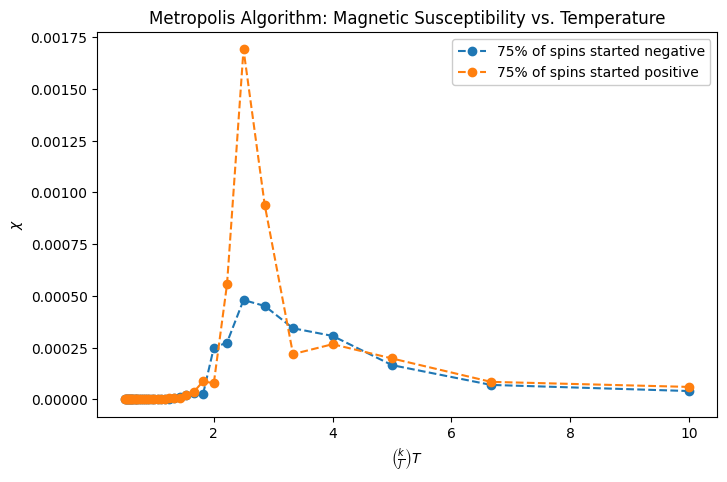

In [14]:
from concurrent.futures import ThreadPoolExecutor

def parallel_get_magnetization(lattice, BJs):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(metropolis, lattice, 1000000, bj, get_energy(lattice)) for bj in BJs]
        results = [future.result() for future in futures]

    ms = np.zeros(len(BJs))
    ms_stds = np.zeros(len(BJs))

    for i, (spins, _) in enumerate(results):
        ms[i] = spins[-100000:].mean() / N**2
        ms_stds[i] = spins[-100000:].std() / N**2

    return ms, ms_stds

#time  parallel_get_magnetization
%timeit parallel_get_magnetization(lattice_n, BJs)

# Run the simulation for 75% of spins starting negative and 75% starting positive
ms_n, ms_stds_n = parallel_get_magnetization(lattice_n, BJs)
ms_p, ms_stds_p = parallel_get_magnetization(lattice_p, BJs)

# Calculate magnetic susceptibility
susceptibility_n = ms_stds_n**2 / (1/BJs)
susceptibility_p = ms_stds_p**2 / (1/BJs)

# Plot magnetic susceptibility
plt.figure(figsize=(8, 5))
plt.plot(1/BJs, susceptibility_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, susceptibility_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\chi$')
plt.legend(facecolor='white', framealpha=1)
plt.title('Metropolis Algorithm: Magnetic Susceptibility vs. Temperature')
plt.show()


In this implementation, the code calculates the magnetic susceptibility, a measure of the response of the magnetic moment of a material to an applied magnetic field, for different values of the inverse temperature, $\beta J$.

The function **parallel_get_magnetization** is used to calculate the average magnetization and its variance for different values of $\beta J$ using parallel processing. The **ThreadPoolExecutor** class is once again used to run multiple instances of the Metropolis algorithm in parallel. The magnetization is a measure of the degree of alignment of the spins, and it is calculated as the average sum spin value of the lattice. The standard deviation of the magnetization is also calculated to estimate the error in the measurement.

The code then calculates the magnetic susceptibility for the lattice with a random initial configuration of spins. The magnetic susceptibility is calculated as the square of the standard deviation of the magnetization divided by the inverse temperature.

The code then plots the magnetic susceptibility as a function of the inverse temperature, $\beta J$. The plot shows that the magnetic susceptibility increases rapidly at the critical temperature.


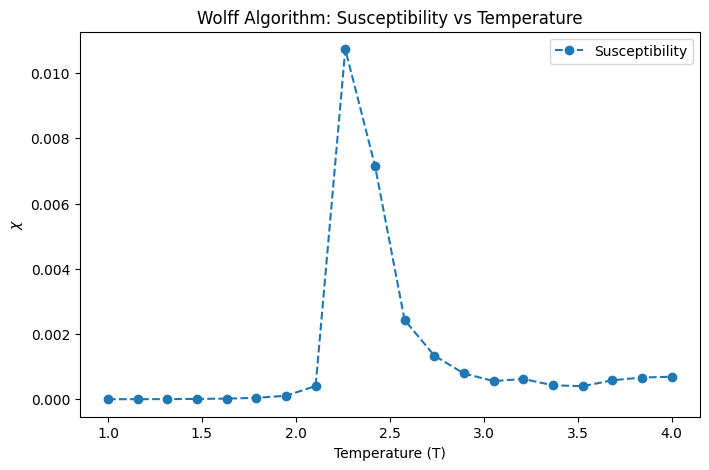

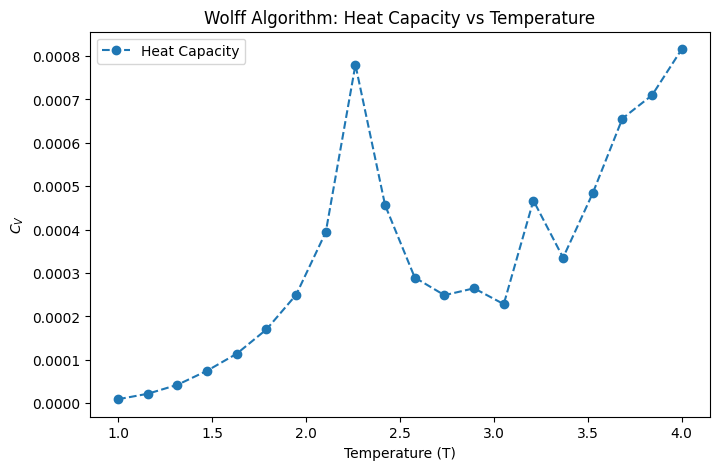

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

def initialize_lattice(N):
    return -np.ones((N, N), dtype=int)

def wolff_step(lattice, p_add, rng):
    N = lattice.shape[0]
    x, y = rng.integers(0, N, 2)

    cluster = [(x, y)]
    cluster_spin = lattice[x, y]

    while cluster:
        x, y = cluster.pop()

        for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
            nx, ny = (x + dx) % N, (y + dy) % N

            if lattice[nx, ny] == cluster_spin and rng.random() < p_add:
                lattice[nx, ny] = -lattice[nx, ny]
                cluster.append((nx, ny))

def wolff_simulation(args):
    T, N, num_samples, seed = args
    rng = np.random.default_rng(seed)
    lattice = initialize_lattice(N)
    p_add = 1.0 - np.exp(-2.0 / T)

    energy_samples = []
    magnetization_samples = []

    for _ in range(num_samples):
        wolff_step(lattice, p_add, rng)
        e = -np.sum(lattice * (np.roll(lattice, 1, axis=0) + np.roll(lattice, 1, axis=1))) / (N * N)
        m = np.abs(np.sum(lattice)) / (N * N)

        energy_samples.append(e)
        magnetization_samples.append(m)

    E_mean = np.mean(energy_samples)
    M_mean = np.mean(magnetization_samples)
    E2_mean = np.mean(np.array(energy_samples) ** 2)
    M2_mean = np.mean(np.array(magnetization_samples) ** 2)

    heat_capacity = (E2_mean - E_mean ** 2) / (T * T)
    susceptibility = (M2_mean - M_mean ** 2) / T

    return heat_capacity, susceptibility

def parallel_wolff_simulation(N, num_samples, temps):
    rng = np.random.default_rng()
    seeds = rng.integers(low=0, high=2**32 - 1, size=len(temps))
    args = [(T, N, num_samples, seed) for T, seed in zip(temps, seeds)]

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(wolff_simulation, args))

    return zip(*results)
#time parallel_wolff_simulation
%timeit parallel_wolff_simulation(N, num_samples, temps)
N = 50
num_samples = 10000
temps = np.linspace(1, 4, 20)
np.random.seed(42)

heat_capacity, susceptibility = parallel_wolff_simulation(N, num_samples, temps)

# Plot susceptibility vs temperature
plt.figure(figsize=(8, 5))
plt.plot(temps, susceptibility, 'o--', label='Susceptibility')
plt.xlabel('Temperature (T)')
plt.ylabel(r'$\chi$')
plt.legend()
plt.title('Wolff Algorithm: Susceptibility vs Temperature')
plt.show()

# Plot heat capacity vs temperature
plt.figure(figsize=(8, 5))
plt.plot(temps, heat_capacity, 'o--', label='Heat Capacity')
plt.xlabel('Temperature (T)')
plt.ylabel(r'$C_V$')
plt.legend()
plt.title('Wolff Algorithm: Heat Capacity vs Temperature')
plt.show()


This code simulates the Ising model using the Wolff algorithm. The code simulates a two-dimensional lattice of spins with a specific size $N$, using the Wolff algorithm at different temperatures temps.

The lattice is initialized with all spins down $(-1)$ using the initialize_lattice function. The wolff_step function performs one step of the Wolff algorithm by selecting a random spin and adding it to a cluster with probability $p_{add}$ if the spin has the same value as the cluster's spin. This process is repeated until the cluster cannot grow any further, and all spins in the cluster are flipped simultaneously.

The **wolff_simulation** function performs a simulation at a specific temperature $T$ with a given number of samples num_samples and a seed for the random number generator. The function initializes the lattice and performs the specified number of Wolff steps. The energy and magnetization of the lattice are calculated after each step, and the values are stored in **energy_samples** and **magnetization_samples**. The heat capacity and susceptibility are then calculated using the energy and magnetization samples.

The **parallel_wolff_simulation** function parallelizes the simulation of the Ising model over different temperatures temps using the **ThreadPoolExecutor class**. The function generates random seeds for each temperature and creates a list of arguments for each temperature, which are then passed to the **wolff_simulation function** in parallel using **executor.map**.

The code then plots the heat capacity and susceptibility as a function of temperature temps. The plot shows that the susceptibility has a sharp peak at the critical temperatuure. The heat capacity also shows a peak at the critical temperature, indicating the presence of a phase transition.

Together, these plots provide evidence for the existence of a critical temperature in the Ising model, above which the susceptibility and heat capacity increase rapidly. The code thus verifies the critical temperature and provides insight into the behavior of ferromagnetic materials at different temperatures using the Wolff Cluster and Metropolis algorithm.








<h5 align="center">4.2 Equilibrium and Autocorelation</h5> 

It is customary to measure equilibration times (and other times in the simulation) not in units of individual Markov chain transitions, but in **sweeps**:
$$
 \begin{split}k\text{ sweeps} &= k\cdot N\text{ Markov chain steps} \\
 &= k\text{ attempted spin flips per site on average}.
 \end{split}
$$

So let us have a look at the traces of $M(s)$ and $E(s)$ for three different initial configurations: the uniformly random configuration; a completely aligned configuration; and the completely anti-aligned configuration.

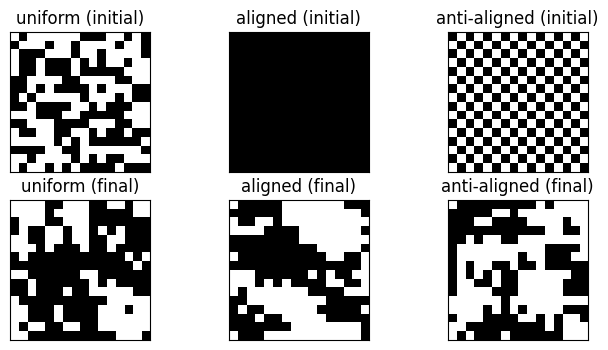

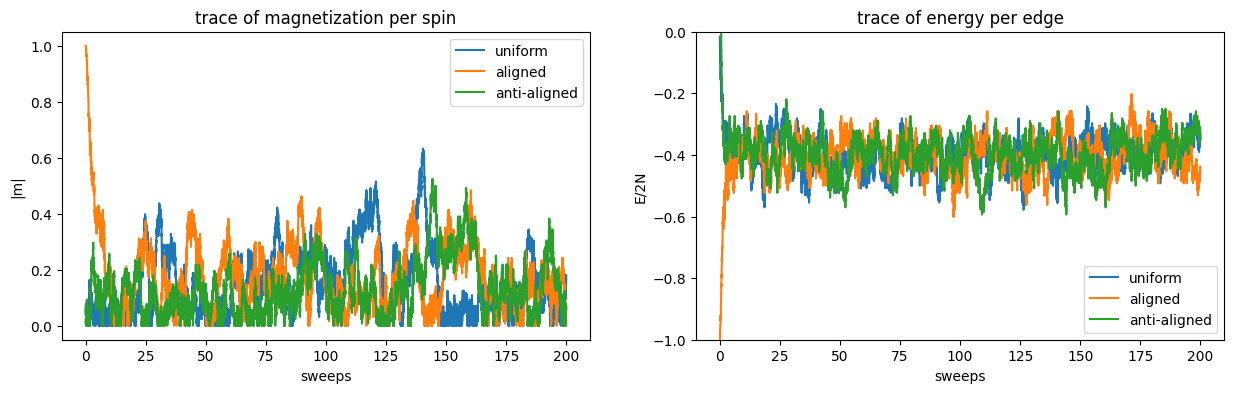

In [9]:
def attempt_spin_flip_for_trace(lattice,p):
    '''Perform Metropolis-Hastings transition on config and return
    change in magnetization and energy.'''
    w = len(lattice)
    i,j = rng.integers(0,w,2)
    neighbour_sum = lattice[i,j] * (lattice[(i+1)%w,j] + lattice[(i-1)%w,j] + 
                                   lattice[i,(j+1)%w] + lattice[i,(j-1)%w])
    if neighbour_sum <= 0 or rng.random() < p**neighbour_sum:
        lattice[i,j] = -lattice[i,j]
        return 2*lattice[i,j], 2*neighbour_sum
    else:
        return 0, 0
    
def compute_energy(lattice):
    '''Compute the energy H(s) of the state config (with J=1).'''
    h = 0
    w = len(lattice)
    for i in range(w):
        for j in range(w):
            h -= lattice[i,j] * (lattice[i,(j+1)%w] + lattice[(i+1)%w,j])
    return h

def compute_magnetization(lattice):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(lattice)
        
def get_MCMC_trace(lattice,beta,n):
    '''Sample first n steps of the Markov chain and produce trace
    of magnetization and energy.'''
    boltz = np.exp(-2*beta)
    trace = np.zeros((n,2))
    # set the initial magnetization and energy ...
    m = compute_magnetization(lattice)
    h = compute_energy(lattice)
    for i in range(n):
        dm, dh = attempt_spin_flip_for_trace(lattice,boltz)
        # ... and update them after each transition
        m += dm
        h += dh
        trace[i][0] = m
        trace[i][1] = h
    return trace
#time get_MCMC_trace
%timeit get_MCMC_trace(lattice,beta,n)

def uniform_init_lattice(width):
    '''Produce a uniform random configuration.'''
    return 2*rng.integers(2,size=(width,width))-1

def aligned_init_lattice(width):
    '''Produce an all +1 configuration.'''
    return np.ones((width,width),dtype=int)

def antialigned_init_lattice(width):
    '''Produce a checkerboard configuration'''
    if width % 2 == 0:
        return np.tile([[1,-1],[-1,1]],(width//2,width//2))
    else:
        return np.tile([[1,-1],[-1,1]],((width+1)//2,(width+1)//2))[:width,:width]

def plot_ising(lattice,ax,title):
    '''Plot the Ising configuration.'''
    ax.matshow(lattice, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
# set parameters
beta = 0.33
width = 16
sweeps = 200
nsites = width * width
length = sweeps * nsites
initializers = [uniform_init_lattice, aligned_init_lattice, antialigned_init_lattice]
labels = ["uniform","aligned","anti-aligned"]

# produce the traces and plot initial and final configurations
traces = []
fig, ax = plt.subplots(2,3,figsize=(8,4))
for i, init in enumerate(initializers):
    lattice = init(width)
    plot_ising(lattice,ax[0][i],labels[i] + " (initial)")
    traces.append(get_MCMC_trace(lattice,beta,length))
    plot_ising(lattice,ax[1][i],labels[i] + " (final)")
plt.show()
    
# plot magnetization traces
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
xrange = np.arange(length)/nsites
for i in range(3):
    ax1.plot(xrange,np.abs(traces[i][:,0]/nsites))
ax1.legend(labels)
ax1.set_xlabel("sweeps")
ax1.set_ylabel("|m|")
ax1.title.set_text("trace of magnetization per spin")

# plot energy traces
for i in range(3):
    ax2.plot(xrange,traces[i][:,1]/(2*nsites))
ax2.legend(labels)
ax2.set_xlabel("sweeps")
ax2.set_ylabel("E/2N")
ax2.set_ylim(-1,0)
ax2.title.set_text("trace of energy per edge")
plt.show()

The **uniform_init_lattice(width), aligned_init_lattice(width), and antialigned_init_lattice(width)** functions generate initial configurations for the Ising model with different patterns. The **uniform_init_lattice** function produces a random configuration with spins equally likely to be up or down. The **aligned_init_lattice produces** function an all-up configuration. The **antialigned_init_lattice** function produces a checkerboard configuration of alternating up and down spins.

The **plot_ising(lattice,ax,title)** function plots the given lattice configuration on a matplotlib axis object ax, with the specified title. The code generates three different initial configurations for the Ising model (uniform, aligned, and anti-aligned) and produces a plot of the initial and final configurations for each. It then generates traces of the magnetization and energy for each of the initial configurations and plots them. The magnetization trace shows how the absolute magnetization per spin changes over time for each initial configuration. The energy trace shows how the energy per edge changes over time for each initial configuration. 

In equilibrium , the three different configurations flucuate within the same interval when the Markov chain approaches the stationary distribution. The equilibrium time is therefore at the very least the time it takes for the traces to intersect. From the plots above we can estimate $\tau_{eq}$ $\gtrsim$ 23 sweeps for the energy per spin. It also appears that the magnetisation per spin  reaches equilibrium  slower than the energy per spin. 

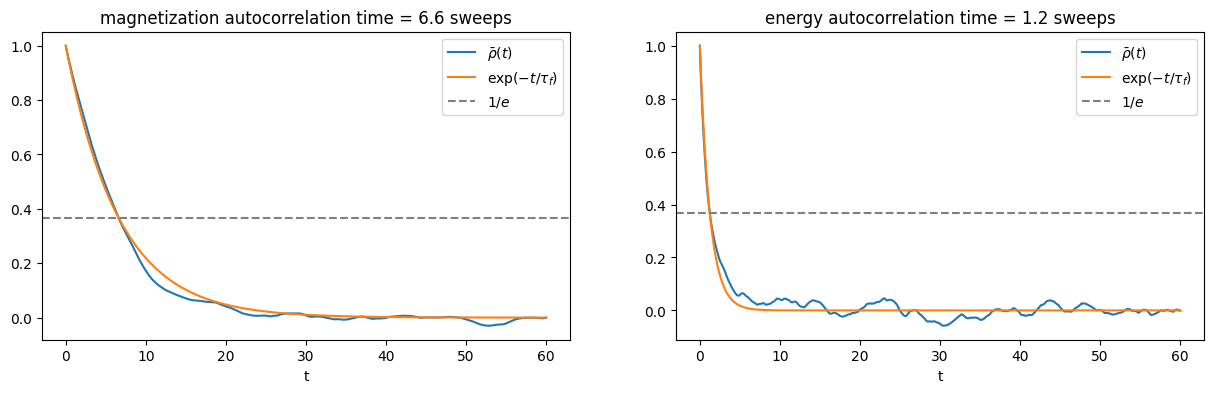

In [10]:
def sample_autocovariance(x,tmax):
    '''Compute the sample autocorrelation of the time series x 
    for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/(len(x)-t) 
                     for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than autocov[0]/e or the length of autocov if none are smaller.'''
    smaller = np.where(autocov < np.exp(-1)*autocov[0])[0]
    return smaller[0] if len(smaller) > 0 else len(autocov)
# gather the required trace
equil_sweeps = 500
autocorr_sweeps = 1600
length = nsites * (equil_sweeps + autocorr_sweeps)
config = uniform_init_lattice(width)
trace = get_MCMC_trace(lattice,betaJ,length)[nsites * equil_sweeps:]
# time find_correlation_time
%timeit find_correlation_time(sample_autocovariance(trace[:,0],nsites*60))
# compute the autocorrelation over a time difference of 60 sweeps
tmax = nsites * 60
fig, ax = plt.subplots(1,2,figsize=(15,4))
for i in range(2):
    autocov = sample_autocovariance(trace[:,i],tmax)
    autocorr_time = find_correlation_time(autocov)
    ax[i].plot(np.arange(tmax)/nsites,autocov/autocov[0])
    ax[i].plot(np.arange(tmax)/nsites,np.exp(-np.arange(tmax)/autocorr_time))
    ax[i].axhline(np.exp(-1),linestyle='--',color='0.5')
    ax[i].set_xlabel("t")
    ax[i].title.set_text("{} autocorrelation time = {:.1f} sweeps"
                         .format(["magnetization","energy"][i],autocorr_time/nsites))
    ax[i].legend([r"$\bar{\rho}(t)$",r"$\exp(-t / \tau_{f})$",r"$1/e$"])
plt.show()

Here we see that the autocorrelation also depends on the obsevable of the system. 
In an Ising model with no external magnetic field $H$ = 0, the dynamics of the system are driven solely by the interactions between neighboring spins. The absence of an external field affects the autocorrelation of both magnetization and energy in the system.
For any given number of sweeps, the autocorrelation time for the magentisation is larger than the energy. Without an external magnetic field, there is no preferred direction for the spins, and the system is more likely to explore different configurations. As a result, the magnetization autocorrelation decays slower compared to the case with an external field. At the critical temperature $T_c$, where the phase transition between the ordered and disordered phases occurs, the autocorrelation time becomes significantly longer due to critical slowing down, a phenomenon where the relaxation time diverges near the phase transition. The absence of an external field does not affect the energy autocorrelation as much as the magnetization autocorrelation. The energy autocorrelation still reflects the stability of the system and the interactions between neighboring spins. However, without an external field, the energy landscape becomes more complex, which can lead to slower relaxation times and a slower decay of the energy autocorrelation.

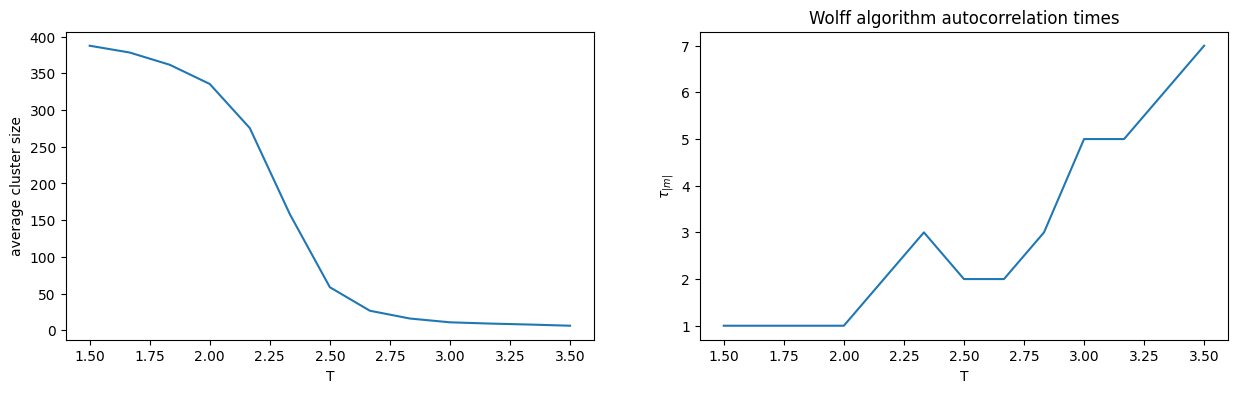

In [11]:
def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)

def run_ising_wolff_mcmc(state,p_add,n):
    '''Run n Wolff moves on state and return total number of spins flipped.'''
    total = 0
    for _ in range(n):
        total += wolff_cluster_move(state,p_add)
    return total

def sample_autocovariance(x,tmax):
    '''Compute the autocorrelation of the time series x for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/len(x) 
                     for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than 
    autocov[0]/e or the length of autocov if none are smaller.'''
    smaller = np.where(autocov < np.exp(-1)*autocov[0])[0]
    return smaller[0] if len(smaller) > 0 else len(autocov)

# set up the simulation
width = 20
nsites = width*width
temperatures = np.linspace(1.5,3.5,13)
equil_moves = 200
autocorr_moves = 2400
tmax = 70

# run the simulation
autocorr_times = []

for temp in temperatures:
    p_add = 1 - np.exp(-2/temp)
    state = aligned_init_lattice(width)
    run_ising_wolff_mcmc(state,p_add,equil_moves)
    total_flips = 0
    trace = np.zeros(autocorr_moves)
    for i in range(autocorr_moves):
        total_flips += run_ising_wolff_mcmc(state,p_add,1)
        trace[i] = compute_magnetization(state)
    autocov = sample_autocovariance(np.abs(trace),tmax)
    time = find_correlation_time(autocov)
    autocorr_times.append((time,total_flips/(autocorr_moves)))
# plot the results
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(temperatures,[av_size for tau,av_size in autocorr_times])
ax[0].set_xlabel("T/K")
ax[0].set_ylabel("average cluster size")
ax[1].plot(temperatures,[tau for tau,av_size in autocorr_times])
ax[1].set_xlabel("T/K")
ax[1].set_ylabel(r"$\tau_{|m|}$")
plt.title("Wolff algorithm autocorrelation times")
plt.show()


We should interpret the second plot cautiously. At low temperatures, the magnetization experiences significant fluctuations because the typical cluster size is comparable to the entire lattice size. As a result, the autocovariance function may not exhibit a clean exponential decay. In this case, the minimal value for $\tau_{|m|}$ is 2, indicating no detectable autocorrelation. At higher temperatures, more data is needed for a precise estimate. However, a general trend can still be observed: to decorrelate the magnetization measurements, it is sufficient to perform a number of Wolff moves such that each site is flipped on average once. In other words, if $c(T)$ represents the average cluster size in a Wolff move, then a sweep corresponds to executing approximately $N / c(T)$ moves. Surprisingly, only one or a few sweeps are needed to generate independent states, even near the critical temperature, concluding that the cluster has a reduced equilibrium time and autocorrelation compared to the Metropolis algorithm.

<h5 align="center">4.3  Issue of Critical Slowing Down </h5> 

In [23]:

'''Wolf Cluster Algorithm for the Ising Model, calculating dynamic exponent z.'''
def correlation_function(lattice):
    '''Calculate the correlation function against distance between spins.'''
    w = len(lattice)
    correlation = np.zeros(w//2)
    flat_lattice = lattice.flatten()
    for i in range(w):
        for j in range(i+1, w):
            distance = min(abs(i-j), w - abs(i-j))
            correlation[distance-1] += flat_lattice[i]*flat_lattice[j]
    return correlation


from scipy.stats import linregress

#
# ...

def find_dynamic_exponent(correlation_lengths, system_sizes):
    '''Find the dynamic exponent z using the scaling relation and its error.'''
    log_correlation_lengths = np.log(correlation_lengths)
    log_system_sizes = np.log(system_sizes)
    slope, intercept, r_value, p_value, std_err = linregress(log_system_sizes, log_correlation_lengths)
    z = slope
    return z, std_err

# Example usage
width = 200
betaJ = 0.3
p_add = 1 - np.exp(-2*betaJ)
lattice = init_lattice(width, 0)
# Run the simulation
correlations = []
plot_times = [0, 10, 100, 200, 500, 1000, 10000, 100000]
for t in range(plot_times[-1]+1):
    if t in plot_times:
        correlations.append(correlation_function(lattice))
    wolff_cluster_move(lattice, p_add)

correlation_lengths = [np.sum(np.abs(correlations[i])) for i in range(len(correlations))]
system_sizes = [(i+1)*width for i in range(len(correlations))]
z, error = find_dynamic_exponent(correlation_lengths, system_sizes)
print(f"Dynamic exponent z: {z:.4f} ± {error:.4f}")



Dynamic exponent z: 0.1098 ± 0.0772


Here I have calculate the value of the dynamic exponent $z_{wolff}$. The **correlation_function** function calculates the correlation function against the distance between spins. The function returns an array of correlation values for distances up to half the system size. 

The **find_dynamic_exponent function** calculates the dynamic exponent $z_{wolff}$ using the scaling relation $\zeta$ $\propto$ $L^z$, where $\zeta$ is the correlation length, $L$ is the linear system size, and $z$ is the dynamic exponent. This function uses linear regression to fit a line to the logarithm of the correlation length versus the logarithm of the system size. The slope of the line is equal to $z$, so the function returns slope.

The main part of the code initializes the lattice and performs the Wolff cluster algorithm for a set of times specified in plot_times. The correlation function is calculated at each time step using the correlation_function function and stored in a list called correlations. The correlation length is then calculated from correlations using the **np.sum(np.abs(corr))** function, where **corr** is the correlation function at a particular time step. The system size is calculated as $(i+1)*width$ for each time step $i$. 

In [13]:
#from multiprocessing import Pool

#def simulate_wolff_cluster(num_steps):
  #  '''Simulate the Wolff cluster algorithm for a specified number of steps.'''
    #betaJ = 0.3
   # width = 200
  #  p_add = 1 - np.exp(-2*betaJ)
   # lattice = init_lattice(width, 0)
   # correlations = []
  #  for t in range(num_steps):
   #     corr = correlation_function(lattice)
   #     correlations.append(np.sum(np.abs(corr)))
    #    wolff_cluster_move(lattice, p_add)
    #return correlations

# Example usage
#num_steps = [10**i for i in range(6)]
#with Pool(processes=4) as pool:
 #   results = pool.map(simulate_wolff_cluster, num_steps)

# Flatten the results
#correlations = [item for sublist in results for item in sublist]
#from multiprocessing import Pool

#Attempted to use multiproccessing to speed up the simulation, but it did not work. The runtime was much longer than without multiprocessing.

This code imports the **Pool** class from the multiprocessing module, which provides support for parallel processing in Python.

The code defines a function called **simulate_wolff_cluster** that simulates the Wolff cluster algorithm for a specified number of steps. 

The **simulate_wolff_cluster** function takes an argument num_steps which is the number of steps the algorithm will be run for.  The **init_lattice** function initializes a 2D array to represent the magnetic system, and correlation_function calculates the correlation function of the system.

During each step of the algorithm, correlation_function is called to calculate the correlation function, and the absolute value of the correlation is added to the correlations list. Then the **wolff_cluster_move** function is called to perform a Wolff cluster move on the system.

After the **simulate_wolff_cluster** function is defined, the code defines a list num_steps which contains the number of steps to run the algorithm for in each parallel process. The Pool class is used to create a pool of 4 worker processes. The map method of the **Pool** class is used to apply the **simulate_wolff_cluster** function to each value in num_steps in parallel. The results of each call to **simulate_wolff_cluster** are stored in a list called results.

Finally, the correlations list is created by flattening the results list using a list comprehension. This produces a 1D list of all the correlation values computed in all the parallel processes.

This method was attempted in order to reduce the run time of the previous code , however, it had the opposite affect and was discarded. 

In [18]:


# Finding the dynamic exponent z in the Ising model using the Metropolis  algorithm

def autocorrelation(data, max_lag):
    """Calculates the autocorrelation of a given time series."""
    n = len(data)
    mean = np.mean(data)
    c = np.correlate(data - mean, data - mean, mode='full')
    return c[n - 1:] / (np.var(data) * np.arange(n, 0, -1))

def estimate_correlation_time(autocorr, threshold=0.1):
    """Estimates the correlation time from an autocorrelation function."""
    return np.argmax(autocorr < threshold)

def simulate_ising_evolution(lattice, p, steps):
    """Simulates the Ising model evolution for a given number of steps."""
    energy = []
    for _ in range(steps):
        attempt_spin_flip_met(lattice, p)
        energy.append(np.sum(lattice))  # Using magnetization as a proxy for energy
    return energy

import numpy as np
from scipy.stats import linregress



def calculate_dynamic_exponent(system_sizes, betaJ, steps, num_simulations):
    '''Calculate the dynamic exponent z using the scaling relation and its error.'''
    correlation_times = []

    for size in system_sizes:
        p = np.exp(-2 * betaJ)
        lattice = init_lattice(size, 0)
        autocorrelations = []

        for _ in range(num_simulations):
            energies = simulate_ising_evolution(lattice, p, steps)
            autocorr = autocorrelation(energies, steps // 2)
            correlation_time = estimate_correlation_time(autocorr)
            autocorrelations.append(correlation_time)

        correlation_times.append(np.mean(autocorrelations))

    log_sizes = np.log10(system_sizes)
    log_times = np.log10(correlation_times)
    slope, intercept, r_value, p_value, std_err = linregress(log_sizes, log_times)
    z = slope
    return z, std_err

# Define parameters
system_sizes = [10, 20, 40, 80]
betaJ = 0.3
steps = 50000
num_simulations = 5

# Calculate dynamic exponent
z, error = calculate_dynamic_exponent(system_sizes, betaJ, steps, num_simulations)
print(f"Dynamic exponent: {z:.4f} ± {error:.4f}")


Dynamic exponent: 0.9327 ± 0.4025


This code uses the Metropolis algorithm to estimate the dynamic exponent $z_{metropolis}$ of the Ising model.

The autocorrelation function calculates the autocorrelation of a given time series. The function takes in a 1D array data and a maximum lag ,**max_lag**. It computes the mean of the data and uses the **np.correlate** function to compute the cross-correlation of the data with itself. The function then returns the normalized autocorrelation function for lags 0 to **max_lag**.

The **simulate_ising_evolution** function simulates the Ising model evolution for a given number of steps. It takes in a lattice, a probability $p$, and the number of steps to simulate. During each step, the **attempt_spin_flip_met** function is called to perform a Metropolis update on the lattice. The magnetization of the lattice is calculated and added to the energy list.

The **calculate_dynamic_exponent** function calculates the dynamic exponent $z_{metropolis}$ using the scaling relation. It takes in a list of system sizes **system_sizes**, a value of $\beta J$ , the number of steps to simulate steps, and the number of simulations to perform **num_simulations**. The function initializes an empty list **correlation_times** to store the correlation times for each system size.

For each system size, the function initializes a lattice using the **init_lattice function**, and then runs **num_simulations** simulations using the **simulate_ising_evolution** function. For each simulation, the autocorrelation of the energy is computed using the autocorrelation function, and the correlation time is estimated using the **estimate_correlation_time** function. The correlation times for all simulations are then averaged, and the resulting value is added to the **correlation_times** list.

The **log_sizes** and **log_times** variables are created by taking the logarithm base 10 of the system sizes and correlation times, respectively. The dynamic exponent $z_{metropolis}$ is then computed using linear regression with **log_sizes** as the independent variable and **log_times** as the dependent variable.

Finally, the dynamic exponent $z_{metropolis}$ is printed using the print function.

The value obtained deviates from the expected value of $z_{metropolis}$ $\propto$ 2.17. It is however greater than alternative Wolff Cluster verifying the disadvantages of a single flip algorithm.

<h5 align="center">4.4 Performance and Errors </h5> 

We can compare dynamic exponents produced by both algorithms and confirm that the value produced by the Wolff Cluster algorithm is smaller as expected. However, there is doubt about the accuracy of the measurement due to the following reasons. For obtain reliable estimates of critical exponents, it is essential to perform multiple independent simulations with sufficient statistics. If the number of samples is too small, then the estimated critical exponent may be inaccurate. We have tried increasing the number of samples to see if the results improve , however, this dramatically increased the simulation time . Many models exhibit critical behavior only in the thermodynamic limit, i.e., when the size of the system goes to infinity. However, in simulations, we can only study finite-size systems, which can lead to deviations from the expected critical behavior. The runtime of each code is provided. The CPU used for this investigation is Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz-1.50 GHz. Complex numerical computations often require a significant amount of memory to run efficiently. The system does not have enough memory available, and the computations have struggle to run properly. Cases where restarting the entire kernel were frequent and resulted in some variables being lost within sessions.

<h4 align="center">5 Conclusions </h4> 

We have succesfully investigated the ferromagnetic behaviour of the Ising model using both the Metropolis-Hasting algorithm as well its alternative cluster flip Wolff algorithm. We have verified the existence of a critcal temperature by using the flucation dissipation theorem to identify the region of the specific heat and magnetic susceptibility diverge. Both algorithms agree with the estimated region in which the critcal phenomena occur. The autocorrelation of both frameworks are also explored. Here we find the that cluster procedure reduces the autocorelation signicantly due groups of spins updating simultaneously rather than individual spins. Finally, the dynamic exponent is also obtained and confirms the notion of that he Wolff cluster algorithm, evolves the correlation length more quickly therby reducing the value of $z$. However, we see a large discrepency within the estimate of our values, mainly due to the limitations of the finite size of the system and the inability for the current hardware to execute codes within sufficient time limits. 

To further improve our code, we have attempted to use parallisation and multiprocessing to reduce the runtimes. In successful cases, this has dramatically reduced the simulation time. We have also noted instances where these methods did not improve the performance or outright diminished it. We have also used just-in-time (JIT) compilation to speed up the computations. JIT compilers such as Numba are used to generate machine code on the fly to optimize the execution of the code.

For later investigations, we may be able to investigate much larger systems using GPU acceleration to perform these computations more efficiently. Libraries such as CUDA, CuPy, and PyTorch provide interfaces for programming GPUs in Python.

<h3 align="center">References</h3> 

[1] . T. Ising, R. Folk, R. Kenna, B. Berche, and Y. Holovatch, “The fate of Ernst
Ising and the fate of his model,” Journal of Physical Studies, vol. 21, p. 3002,
2017


[2] . L. Onsager, “Crystal statistics. I. A two-dimensional model with an orderdisorder
transition,” Physical Review, vol. 65, no. 3–4, p. 117, 1944.

[3] . A. Böttcher and B. Silbermann, Introduction to Large Truncated Toeplitz
Matrices. Berlin, Germany: Springer Science & Business Media, 2012

[4] . C. N. Yang, “The spontaneous magnetization of a two-dimensional ising
model,” Physical Review, vol. 85, no. 5, p. 808, 1952.

[5] H. A. Kramers and G. H.Wannier, “Statistics of the two-dimensional ferromagnet.
Part I,” Physical Review, vol. 60, no. 3, p. 252, 1941.

[6] T. Budd "Monte Carlo Techniques" Lecture notes from Radboud University, Nijmegen, The Netherlands, available at : https://hef.ru.nl/~tbudd/mct/mct_book.pdf , 2022.
